In [22]:
import pandas as pd
import numpy as np
import sklearn.datasets as ds
import sklearn.preprocessing as preprocessing
import sklearn.model_selection as model_selection
import shap
shap.initjs()

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import xgboost as xg
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Leitura dos Dados

Como ainda não há nenhum dado, vou pegar um dataset arbitrário aqui

In [2]:
def load_dataset(path):
    """
    Load dataset from file.

    The target variable must be in column named "target".

    Parameters
    ----------
    path: str
        path to file

    Returns
    -------
    dataset: pd.DataFrame
    """
    data = ds.load_diabetes(as_frame=True)
    dataset = data["frame"]
    dataset.insert(0, "player_id", np.random.choice(range(1, 30), len(dataset)))

    return dataset

In [3]:
dataset = load_dataset("")
dataset

,player_id,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,20,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,12,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,8,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,13,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,17,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0
...,...,...,...,...,...,...,...,...,...,...,...,...
437,17,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
438,25,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485,104.0
439,18,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491,132.0
440,21,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930,220.0


# Transformação de Features Categóricos em Numéricos

In [4]:
def categorical_to_one_hot_encoding(dataset, categorical_columns):
    """
    Convert categorical columns to one hot encoding.

    Parameters
    ----------
    dataset : pd.DataFrame
        The dataset to be converted.
    categorical_columns : list
        The list of categorical columns.

    Returns
    -------
    dataset_converted : pd.DataFrame
        The converted dataset.
    """
    dataset_converted = dataset.copy()
    for column in categorical_columns:
        dataset_converted = pd.concat([dataset_converted, pd.get_dummies(dataset_converted[column], prefix=column, dtype=float)], axis=1)
        dataset_converted.drop(column, axis=1, inplace=True)

    return dataset_converted

In [5]:
dataset_converted = categorical_to_one_hot_encoding(dataset, categorical_columns=[])
dataset_converted

,player_id,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,20,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,12,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,8,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,13,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,17,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0
...,...,...,...,...,...,...,...,...,...,...,...,...
437,17,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
438,25,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485,104.0
439,18,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491,132.0
440,21,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930,220.0


# Divisão do Dataset entre Treino e Teste

In [6]:
def split_dataset(dataset, test_percentage):
    """
    Splits dataset into training data and test data

    Parameters
    ----------
    dataset : pd.DataFrame
        Dataset to split
    test_percentage : float
        Percentage of data to use for test data

    Returns
    -------
    tuple
        Tuple containing training data and test data
    """
    X_train, X_test, y_train, y_test = model_selection.train_test_split(dataset.drop("target", axis=1), dataset["target"], test_size=test_percentage, random_state=42)
    X_train.reset_index(inplace=True, drop=True)
    X_test.reset_index(inplace=True, drop=True)
    return X_train, X_test, y_train, y_test

In [7]:
X_train, X_test, y_train, y_test = split_dataset(dataset_converted, 0.2)
X_train

,player_id,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,27,0.070769,0.050680,0.012117,0.056301,0.034206,0.049416,-0.039719,0.034309,0.027364,-0.001078
1,27,-0.009147,0.050680,-0.018062,-0.033213,-0.020832,0.012152,-0.072854,0.071210,0.000272,0.019633
2,13,0.005383,-0.044642,0.049840,0.097615,-0.015328,-0.016345,-0.006584,-0.002592,0.017036,-0.013504
3,1,-0.027310,-0.044642,-0.035307,-0.029770,-0.056607,-0.058620,0.030232,-0.039493,-0.049872,-0.129483
4,7,-0.023677,-0.044642,-0.065486,-0.081413,-0.038720,-0.053610,0.059685,-0.076395,-0.037129,-0.042499
...,...,...,...,...,...,...,...,...,...,...,...
348,20,-0.096328,-0.044642,-0.076264,-0.043542,-0.045599,-0.034821,0.008142,-0.039493,-0.059471,-0.083920
349,10,0.005383,0.050680,0.030440,0.083844,-0.037344,-0.047347,0.015505,-0.039493,0.008641,0.015491
350,22,0.030811,-0.044642,-0.020218,-0.005670,-0.004321,-0.029497,0.078093,-0.039493,-0.010903,-0.001078
351,29,-0.012780,-0.044642,-0.023451,-0.040099,-0.016704,0.004636,-0.017629,-0.002592,-0.038460,-0.038357


# Normalização das Features

In [8]:
def normalize_data(X_train, X_test, y_train, y_test, index_column):
    """
    Normalize data, including target column, in the dataset

    Parameters
    ----------
    X_train : pd.DataFrame
        Training data
    X_test : pd.DataFrame
        Testing data
    y_train : pd.DataFrame
        Training target column
    y_test : pd.DataFrame
        Testing target column
    index_column : str
        Name of the index column that will not be changed

    Returns
    -------
    X_scaler : sklearn.preprocessing.StandardScaler
        Scaler used to normalize the features dataset
    y_scaler : sklearn.preprocessing.StandardScaler
        Scaler used to normalize the target data
    X_train_normalized : pd.DataFrame
        Normalized training data
    X_test_normalized : pd.DataFrame
        Normalized testing data
    y_train_normalized : pd.DataFrame
        Normalized training target column
    y_test_normalized : pd.DataFrame
        Normalized testing target column
    """
    X_scaler = preprocessing.StandardScaler()
    y_scaler = preprocessing.StandardScaler()
    X_train_normalized = X_scaler.fit_transform(X_train.drop(index_column, axis=1))
    X_test_normalized = X_scaler.transform(X_test.drop(index_column, axis=1))

    X_train_normalized = pd.DataFrame(X_train_normalized, columns=X_train.drop(index_column, axis=1).columns)
    X_train_normalized.insert(0, index_column, X_train[index_column])
    X_train_normalized[index_column] = X_train[index_column]
    X_test_normalized = pd.DataFrame(X_test_normalized, columns=X_test.drop(index_column, axis=1).columns)
    X_test_normalized.insert(0, index_column, X_test[index_column])
    
    y_train_normalized = pd.Series(y_scaler.fit_transform(np.reshape(y_train, (-1, 1))).squeeze(), name="target")
    y_test_normalized = pd.Series(y_scaler.transform(np.reshape(y_test, (-1, 1))).squeeze(), name="target")

    return X_scaler, y_scaler, X_train_normalized, X_test_normalized, y_train_normalized, y_test_normalized

In [9]:
X_scaler, y_scaler, X_train_normalized, X_test_normalized, y_train_normalized, y_test_normalized = normalize_data(X_train, X_test, y_train, y_test, "player_id")
X_train_normalized

,player_id,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,27,1.498365,1.061370,0.219902,1.138874,0.728473,1.055893,-0.824451,0.711038,0.547482,-0.061449
1,27,-0.228858,1.061370,-0.419366,-0.710591,-0.424929,0.272425,-1.529791,1.484286,-0.019757,0.367236
2,13,0.085182,-0.942179,1.018987,1.992473,-0.309589,-0.326699,-0.119111,-0.062210,0.331237,-0.318660
3,1,-0.621409,-0.942179,-0.784662,-0.639458,-1.174640,-1.215508,0.664600,-0.835458,-1.069682,-2.719299
4,7,-0.542899,-0.942179,-1.423930,-1.706457,-0.799784,-1.110167,1.291569,-1.608706,-0.802859,-0.918820
...,...,...,...,...,...,...,...,...,...,...,...
348,20,-2.113102,-0.942179,-1.652240,-0.923991,-0.943960,-0.715141,0.194374,-0.835458,-1.270659,-1.776191
349,10,0.085182,1.061370,0.608029,1.707940,-0.770949,-0.978492,0.351116,-0.835458,0.155454,0.281499
350,22,0.634754,-0.942179,-0.465028,-0.141525,-0.078908,-0.603217,1.683425,-0.835458,-0.253752,-0.061449
351,29,-0.307368,-0.942179,-0.533521,-0.852858,-0.338424,0.114414,-0.354224,-0.062210,-0.830724,-0.833083


In [10]:
y_train_normalized

0     -0.124906
1     -0.047934
2      1.619775
3     -0.368648
4     -1.215331
         ...   
348   -0.253191
349    0.619149
350   -0.073591
351   -1.151188
352    1.902002
Name: target, Length: 353, dtype: float64

# Regressão

In [19]:
def grid_search(X_train, y_train, regressor, param_grid):
    """
    Performs grid search for regression model.

    Parameters
    ----------
    X_train : array-like
        Training data.
    X_test : array-like
        Testing data.
    y_train : array-like
        Training labels.
    y_test : array-like
        Testing labels.
    regressor : object
        Regression model
    param_grid : dict
        Dictionary of parameters to search over.

    Returns
    -------
    best_params : dict
        Best parameters found.
    best_score : float
        Best score.
    """
    grid_search = model_selection.GridSearchCV(regressor, param_grid, scoring='r2', cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    return best_params, best_score

def optimize_model(X_train, y_train, model):
    """
    Performs grid search with cross validation for a given model and returns the best one.

    Parameters
    ----------
    X_train : array-like
        Training data.
    y_train : array-like
        Training labels.
    model : {'linear', 'decision_tree', 'random_forest', 'svr'}
        Name of the model to use.

    Returns
    -------
    best_params : dict
        Best parameters found.
    best_score : float
        Best score.
    """
    if model == "linear":
        regressor = LinearRegression()
        param_grid = {"fit_intercept": [True, False]}
    elif model == "decision_tree":
        regressor = DecisionTreeRegressor(random_state=0)
        param_grid = {
            "criterion": ["squared_error", "friedman_mse", "absolute_error", "poisson"],
            "splitter": ["best", "random"],
            "max_depth": [5, 10, 20, 50, 100, None],
            "min_samples_split": [2, 5, 10, 20, 50, 100]
        }
    elif model == "random_forest":
        regressor = RandomForestRegressor(random_state=0)
        param_grid = {
            "n_estimators": [10, 50, 100, 200],
            "criterion": ["squared_error", "friedman_mse", "absolute_error", "poisson"],
            "max_depth": [5, 10, 20, 50, 100, None],
            "min_samples_split": [2, 5, 10, 20, 50, 100],
            "max_features": ["sqrt", "log2", None]
        }
    elif model == "xgboost":
        regressor = xg.XGBRegressor(random_state=0, objective ='reg:squarederror')
        param_grid = {
            "n_estimators": [10, 50, 100, 200],
            "eta": [0.1, 0.3, 0.7],
            "max_depth": [5, 10, 20, 50, None],
            "sampling_method": ["uniform", "gradient_based"]
        }
    elif model == "svr":
        regressor = SVR()
        param_grid = {
            "kernel": ["linear", "poly", "rbf", "sigmoid"],
            "degree": [2, 3, 4, 5],
            "gamma": ["auto"],
            "C": [0.1, 1, 10]
        }
    else:
        raise ValueError("Model not available")
    
    best_params, best_score = grid_search(X_train, y_train, regressor, param_grid)

    return best_params, best_score

## Linear Regression

In [15]:
best_params, best_score = optimize_model(X_train_normalized, y_train_normalized, model="linear")
print("Best params: ", best_params)
print("Best R2: %.3f" % best_score)

Best params:  {'fit_intercept': True}
Best R2: 0.454


## Decision Tree

In [17]:
# best_params, best_score = optimize_model(X_train_normalized, y_train_normalized, model="decision_tree")
best_params, best_score = optimize_model(X_train, y_train, model="decision_tree")
print("Best params: ", best_params)
print("Best R2: %.3f" % best_score)

Best params:  {'criterion': 'poisson', 'max_depth': 5, 'min_samples_split': 100, 'splitter': 'best'}
Best R2: 0.331


## XGBoost

In [21]:
best_params, best_score = optimize_model(X_train_normalized, y_train_normalized, model="xgboost")
# best_params, best_score = optimize_model(X_train, y_train, model="xgboost")
print("Best params: ", best_params)
print("Best R2: %.3f" % best_score)

Best params:  {'eta': 0.1, 'max_depth': 5, 'n_estimators': 50, 'sampling_method': 'uniform'}
Best R2: 0.348


## Random Forest

In [ ]:
best_params, best_score = optimize_model(X_train, y_train, model="random_forest")
print("Best params: ", best_params)
print("Best R2: %.3f" % best_score)

## SVR

In [ ]:
best_params, best_score = optimize_model(X_train, y_train, model="svr")
print("Best params: ", best_params)
print("Best R2: %.3f" % best_score)

# SHAP Values

In [68]:
def regression_with_shap_value(X, y, model):
    """
    This function takes in a model and returns the SHAP values for the model.
    
    Parameters
    ----------
    X : pd.DataFrame
        The input data.
    y : pd.Series
        The target data.
    model : sklearn model
        The model to be explained.
        
    Returns
    -------
    explainer : shap.explainer
        The SHAP explainer.
    shap_values : numpy array
        The SHAP values for the model.
    """
    model.fit(X, y)
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    return explainer, shap_values

In [69]:
X = pd.concat([X_train, X_test]).drop("player_id", axis=1)
y = pd.concat([y_train, y_test])

params = {'criterion': 'squared_error', 'max_depth': 10, 'min_samples_split': 50, 'splitter': 'random'}
model = DecisionTreeRegressor(**params)
explainer, shap_values = regression_with_shap_value(X, y, model)
shap_values

.values =
array([[  1.89686484,  -1.15274083,  11.03441   , ...,  10.24207992,
         17.95402161,  -8.79863398],
       [  0.52560598,  -1.73957083, -17.66636199, ...,   8.81563779,
        -22.35283599,  -2.18781117],
       [  0.28990147,   0.57392524,  10.72981292, ...,  48.96449683,
         -0.26253562,  -0.72281089],
       ...,
       [  0.25833466,   1.75787289, -13.23874113, ...,  -8.37808162,
        -17.00504071,  -1.01452689],
       [  0.25833466,   1.75787289, -13.23874113, ...,  -8.37808162,
        -17.00504071,  -1.01452689],
       [  0.25833466,   1.0998198 ,  13.34064109, ...,  14.40805513,
        -37.13657304,  -1.01452689]])

.base_values =
array([[152.13348416],
       [152.13348416],
       [152.13348416],
       [152.13348416],
       [152.13348416],
       [152.13348416],
       [152.13348416],
       [152.13348416],
       [152.13348416],
       [152.13348416],
       [152.13348416],
       [152.13348416],
       [152.13348416],
       [152.13348416],
   

In [70]:
shap_values_df = pd.DataFrame(shap_values.values, columns=X.columns)
shap_values_df

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,1.896865,-1.152741,11.034410,-3.373381,0.0,0.0,16.761570,10.242080,17.954022,-8.798634
1,0.525606,-1.739571,-17.666362,-3.990069,0.0,0.0,12.288008,8.815638,-22.352836,-2.187811
2,0.289901,0.573925,10.729813,45.079716,0.0,0.0,2.642582,48.964497,-0.262536,-0.722811
3,0.258335,3.765761,1.307151,-6.302224,0.0,0.0,-16.528299,-5.176167,-10.687415,-1.014527
4,0.258335,1.757873,-11.904415,-8.702432,0.0,0.0,-20.867077,-8.378082,-10.687415,-1.014527
...,...,...,...,...,...,...,...,...,...,...
437,0.258335,1.757873,-13.395529,-8.581499,0.0,0.0,-20.020981,-12.186253,-6.355157,-1.014527
438,0.258335,3.765761,-0.027175,-6.302224,0.0,0.0,-8.876348,-5.176167,-17.005041,-1.014527
439,0.258335,1.757873,-13.238741,-8.702432,0.0,0.0,-13.215125,-8.378082,-17.005041,-1.014527
440,0.258335,1.757873,-13.238741,-8.702432,0.0,0.0,-13.215125,-8.378082,-17.005041,-1.014527


# Visualizações

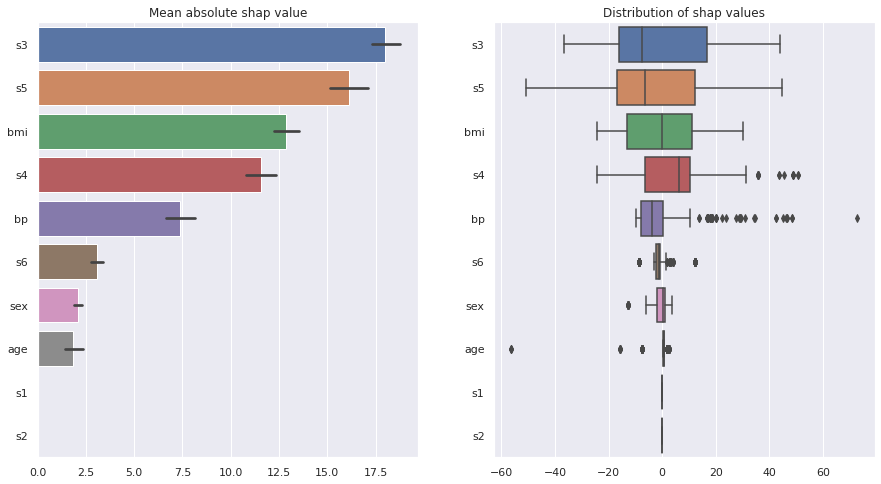

In [71]:
columns = shap_values_df.apply(np.abs).mean().sort_values(ascending=False).index
fig, ax = plt.subplots(1, 2, figsize=(15,8))

sns.barplot(data=shap_values_df[columns].apply(np.abs).values, orient='h', ax=ax[0])
ax[0].set_title("Mean absolute shap value")
ax[0].set_yticklabels(columns)

sns.boxplot(data=shap_values_df[columns].values, orient='h', ax=ax[1])
ax[1].set_title("Distribution of shap values")
ax[1].set_yticklabels(columns);

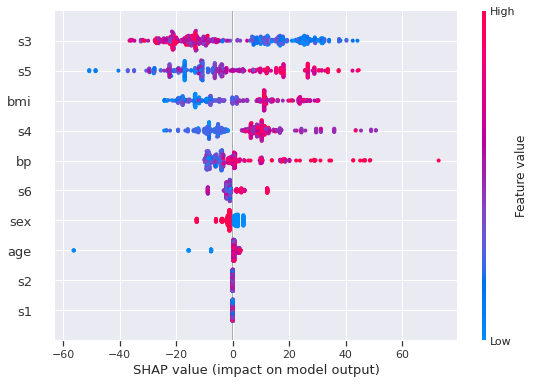

In [72]:
shap.summary_plot(shap_values)

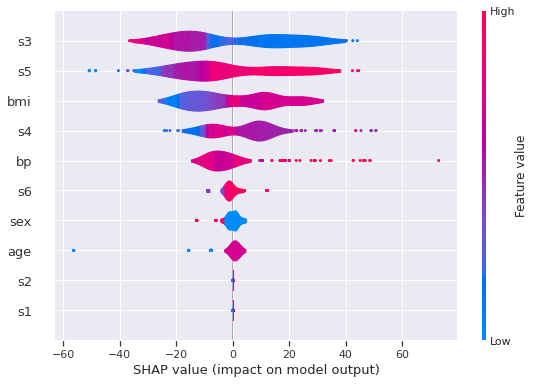

In [73]:
shap.summary_plot(shap_values, plot_type="violin")

In [77]:
shap.force_plot(explainer.expected_value, shap_values.values, X)

In [86]:
class WaterfallData():
    def __init__ (self, shap_test, index):
        self.values = shap_test[index].values
        self.base_values = shap_test[index].base_values[0]
        self.data = shap_test[index].data
        self.feature_names = shap_test.feature_names
        self.display_data = None

def plot_player(shap_values, index):
    shap.plots.waterfall(WaterfallData(shap_values, index))

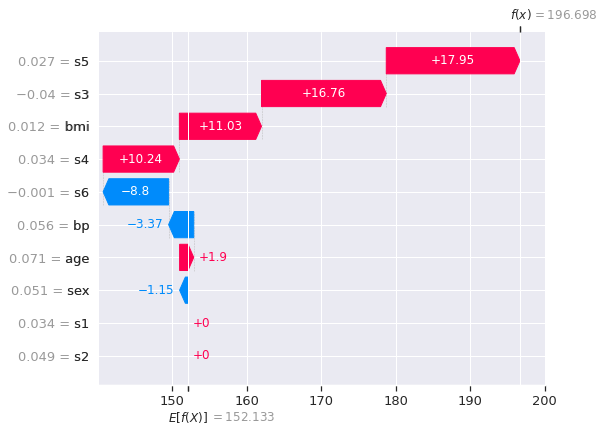

In [87]:
plot_player(shap_values, 0)